In [4]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from IPython.display import display

%matplotlib inline


In [9]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('olistbr/brazilian-ecommerce', path='datasets', unzip=True)

Generally check all the datasets (columns, values, etc)

In [3]:
list_datasets = glob('datasets/*.csv')

# Fix the missing leading 0s issue by converting the value type from int to string of seller and customer zip code columns
dtype_dic = {'seller_zip_code_prefix': str,
             'customer_zip_code_prefix': str}

for dataset in list_datasets:
    df = pd.read_csv(dataset, dtype=dtype_dic)
    print(dataset.split('/')[-1])
    display(df.head(3))


### **Seller Side Analysis**

### 1. Seller State and Sold Prices

In [332]:
df_seller = pd.read_csv('datasets/olist_sellers_dataset.csv')
df_items = pd.read_csv('datasets/olist_order_items_dataset.csv')
df_seller_price = df_seller.merge(df_items, on='seller_id')
df_seller_price.head(3)


,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.2,9.56
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.7,15.92
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.8,2.42


In [333]:
df_seller_price.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   seller_id               112650 non-null  object 
 1   seller_zip_code_prefix  112650 non-null  int64  
 2   seller_city             112650 non-null  object 
 3   seller_state            112650 non-null  object 
 4   order_id                112650 non-null  object 
 5   order_item_id           112650 non-null  int64  
 6   product_id              112650 non-null  object 
 7   shipping_limit_date     112650 non-null  object 
 8   price                   112650 non-null  float64
 9   freight_value           112650 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 9.5+ MB


In [334]:
# Check if there is any missing value in dataset
df_seller_price.isnull().sum()


seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
order_id                  0
order_item_id             0
product_id                0
shipping_limit_date       0
price                     0
freight_value             0
dtype: int64

In [335]:
# Check the price range is valid
max_price = max(df_seller_price['price'])
min_price = min(df_seller_price['price'])
print(max_price, min_price)


6735.0 0.85


#### -- Seller State and Total Sold Price

In [336]:
df_total_by_state = df_seller_price[['seller_state', 'price']].groupby(
    by='seller_state').sum().reset_index().rename(columns={'price': 'total_sold_price'}).sort_values(by='total_sold_price', ascending=False)
df_total_by_state


,seller_state,total_sold_price
22,SP,8753396.21
15,PR,1261887.21
8,MG,1011564.74
16,RJ,843984.22
20,SC,632426.07
19,RS,378559.54
2,BA,285561.56
4,DF,97749.48
13,PE,91493.85
6,GO,66399.21


In [337]:
# Calculate the percentage of SP's total sold price
percentage = df_total_by_state.iloc[0]['total_sold_price'] / \
    df_total_by_state.iloc[:]['total_sold_price'].sum()
percentage = percentage * 100
percentage


64.40277867201597

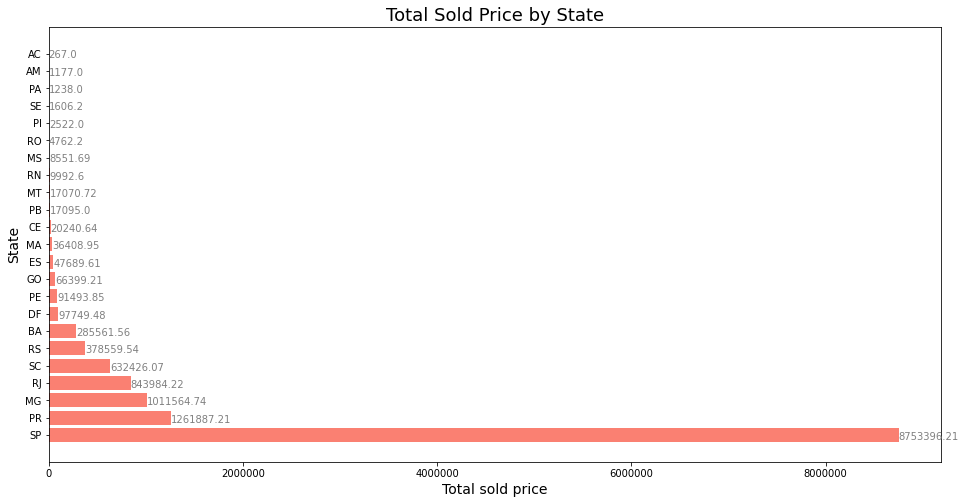

In [338]:
plt.figure(figsize=(16, 8))

plt.barh(df_total_by_state['seller_state'],
         df_total_by_state['total_sold_price'], color='salmon')

y = df_total_by_state['total_sold_price'].values
for index, value in enumerate(y):
    plt.text(value, index+0.2, str(value), va='top', color='grey')

plt.ticklabel_format(axis='x', style='plain')

plt.title("Total Sold Price by State", fontsize=18)
plt.ylabel('State', fontsize=14)
plt.xlabel('Total sold price', fontsize=14)
plt.show()


#### -- Seller State and Average Order Price

In [339]:
df_avg_by_state = df_seller_price[['seller_state', 'order_id']].groupby(by='seller_state').count(
).reset_index().rename(columns={'order_id': 'total_order_num'}).sort_values(by='total_order_num', ascending=False).merge(df_total_by_state, on='seller_state')
df_avg_by_state['avg_order_price'] = df_avg_by_state['total_sold_price'] / \
    df_avg_by_state['total_order_num']
df_avg_by_state.sort_values(by='avg_order_price', ascending=False)


,seller_state,total_order_num,total_sold_price,avg_order_price
16,PB,38,17095.00,449.868421
7,BA,643,285561.56,444.108180
21,AM,3,1177.00,392.333333
17,RO,14,4762.20,340.157143
22,AC,1,267.00,267.000000
13,CE,94,20240.64,215.325957
18,PI,12,2522.00,210.166667
9,PE,448,91493.85,204.227344
14,RN,56,9992.60,178.439286
3,RJ,4818,843984.22,175.173147


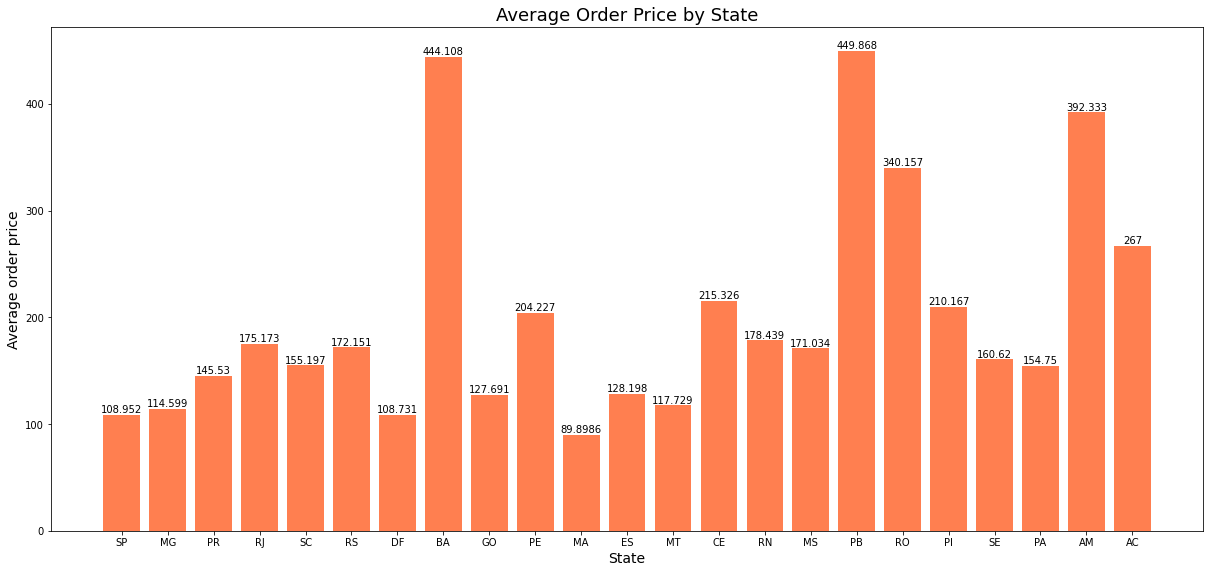

In [340]:
ax = plt.figure(figsize=(16, 7)).add_axes([0, 0, 1, 1])
bars = ax.bar(df_avg_by_state['seller_state'],
              df_avg_by_state['avg_order_price'], color='coral')
ax.bar_label(bars)

ax.set_title("Average Order Price by State", fontsize=18)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Average order price', fontsize=14)
plt.show()


*From the first analysis of the seller state and total sold price we can have a very clear picture of how much each state has sold. The state ranking the first is SP of which the total sold price consist of **64.4%** of the whole country's sold price.*<br><br>
*Based on the second analysis of seller state and average order price we can see the top states are different compared to the total sold price chart where state PB ranks the first with average **449.8** order price. State SP has highest total sold price but the average order price is just **108.9** whcih ranks the thrid to the last.*

### 2. Seller State and Product Category

In [341]:
df_product = pd.read_csv('datasets/olist_products_dataset.csv')
df_seller_product = df_seller_price.merge(df_product, on='product_id', how='left')[
    ['seller_state', 'product_category_name']]
df_seller_product.head(3)


,seller_state,product_category_name
0,SP,esporte_lazer
1,SP,esporte_lazer
2,SP,esporte_lazer


In [342]:
df_seller_product['product_category_name'].unique()


array(['esporte_lazer', 'malas_acessorios', 'papelaria',
       'fashion_bolsas_e_acessorios', 'bebes', 'eletronicos', 'alimentos',
       'telefonia', 'consoles_games', 'informatica_acessorios',
       'brinquedos', 'casa_conforto', 'cool_stuff', 'audio',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'pet_shop',
       'instrumentos_musicais', 'beleza_saude', 'cama_mesa_banho',
       'moveis_decoracao', 'moveis_escritorio', 'ferramentas_jardim',
       'climatizacao', 'automotivo', nan, 'utilidades_domesticas',
       'perfumaria', 'moveis_sala', 'relogios_presentes',
       'artigos_de_natal', 'cine_foto', 'fashion_underwear_e_moda_praia',
       'telefonia_fixa', 'construcao_ferramentas_construcao', 'artes',
       'eletroportateis', 'sinalizacao_e_seguranca',
       'livros_interesse_geral', 'livros_tecnicos', 'pc_gamer',
       'construcao_ferramentas_seguranca', 'bebidas', 'eletrodomesticos',
       'casa_construcao', 'artes_e_artesanato', 'fashion_esporte',
       'a

In [343]:
# Check the missing values
df_seller_product.isnull().sum()


seller_state                0
product_category_name    1603
dtype: int64

In [344]:
# Fill the missing category value with string 'no_category'
df_seller_product['product_category_name'].fillna('no_category', inplace=True)
df_seller_product.isnull().sum()


seller_state             0
product_category_name    0
dtype: int64

In [345]:
df_seller_product


,seller_state,product_category_name
0,SP,esporte_lazer
1,SP,esporte_lazer
2,SP,esporte_lazer
3,SP,malas_acessorios
4,SP,papelaria
...,...,...
112645,RS,no_category
112646,RS,no_category
112647,RS,no_category
112648,RS,no_category


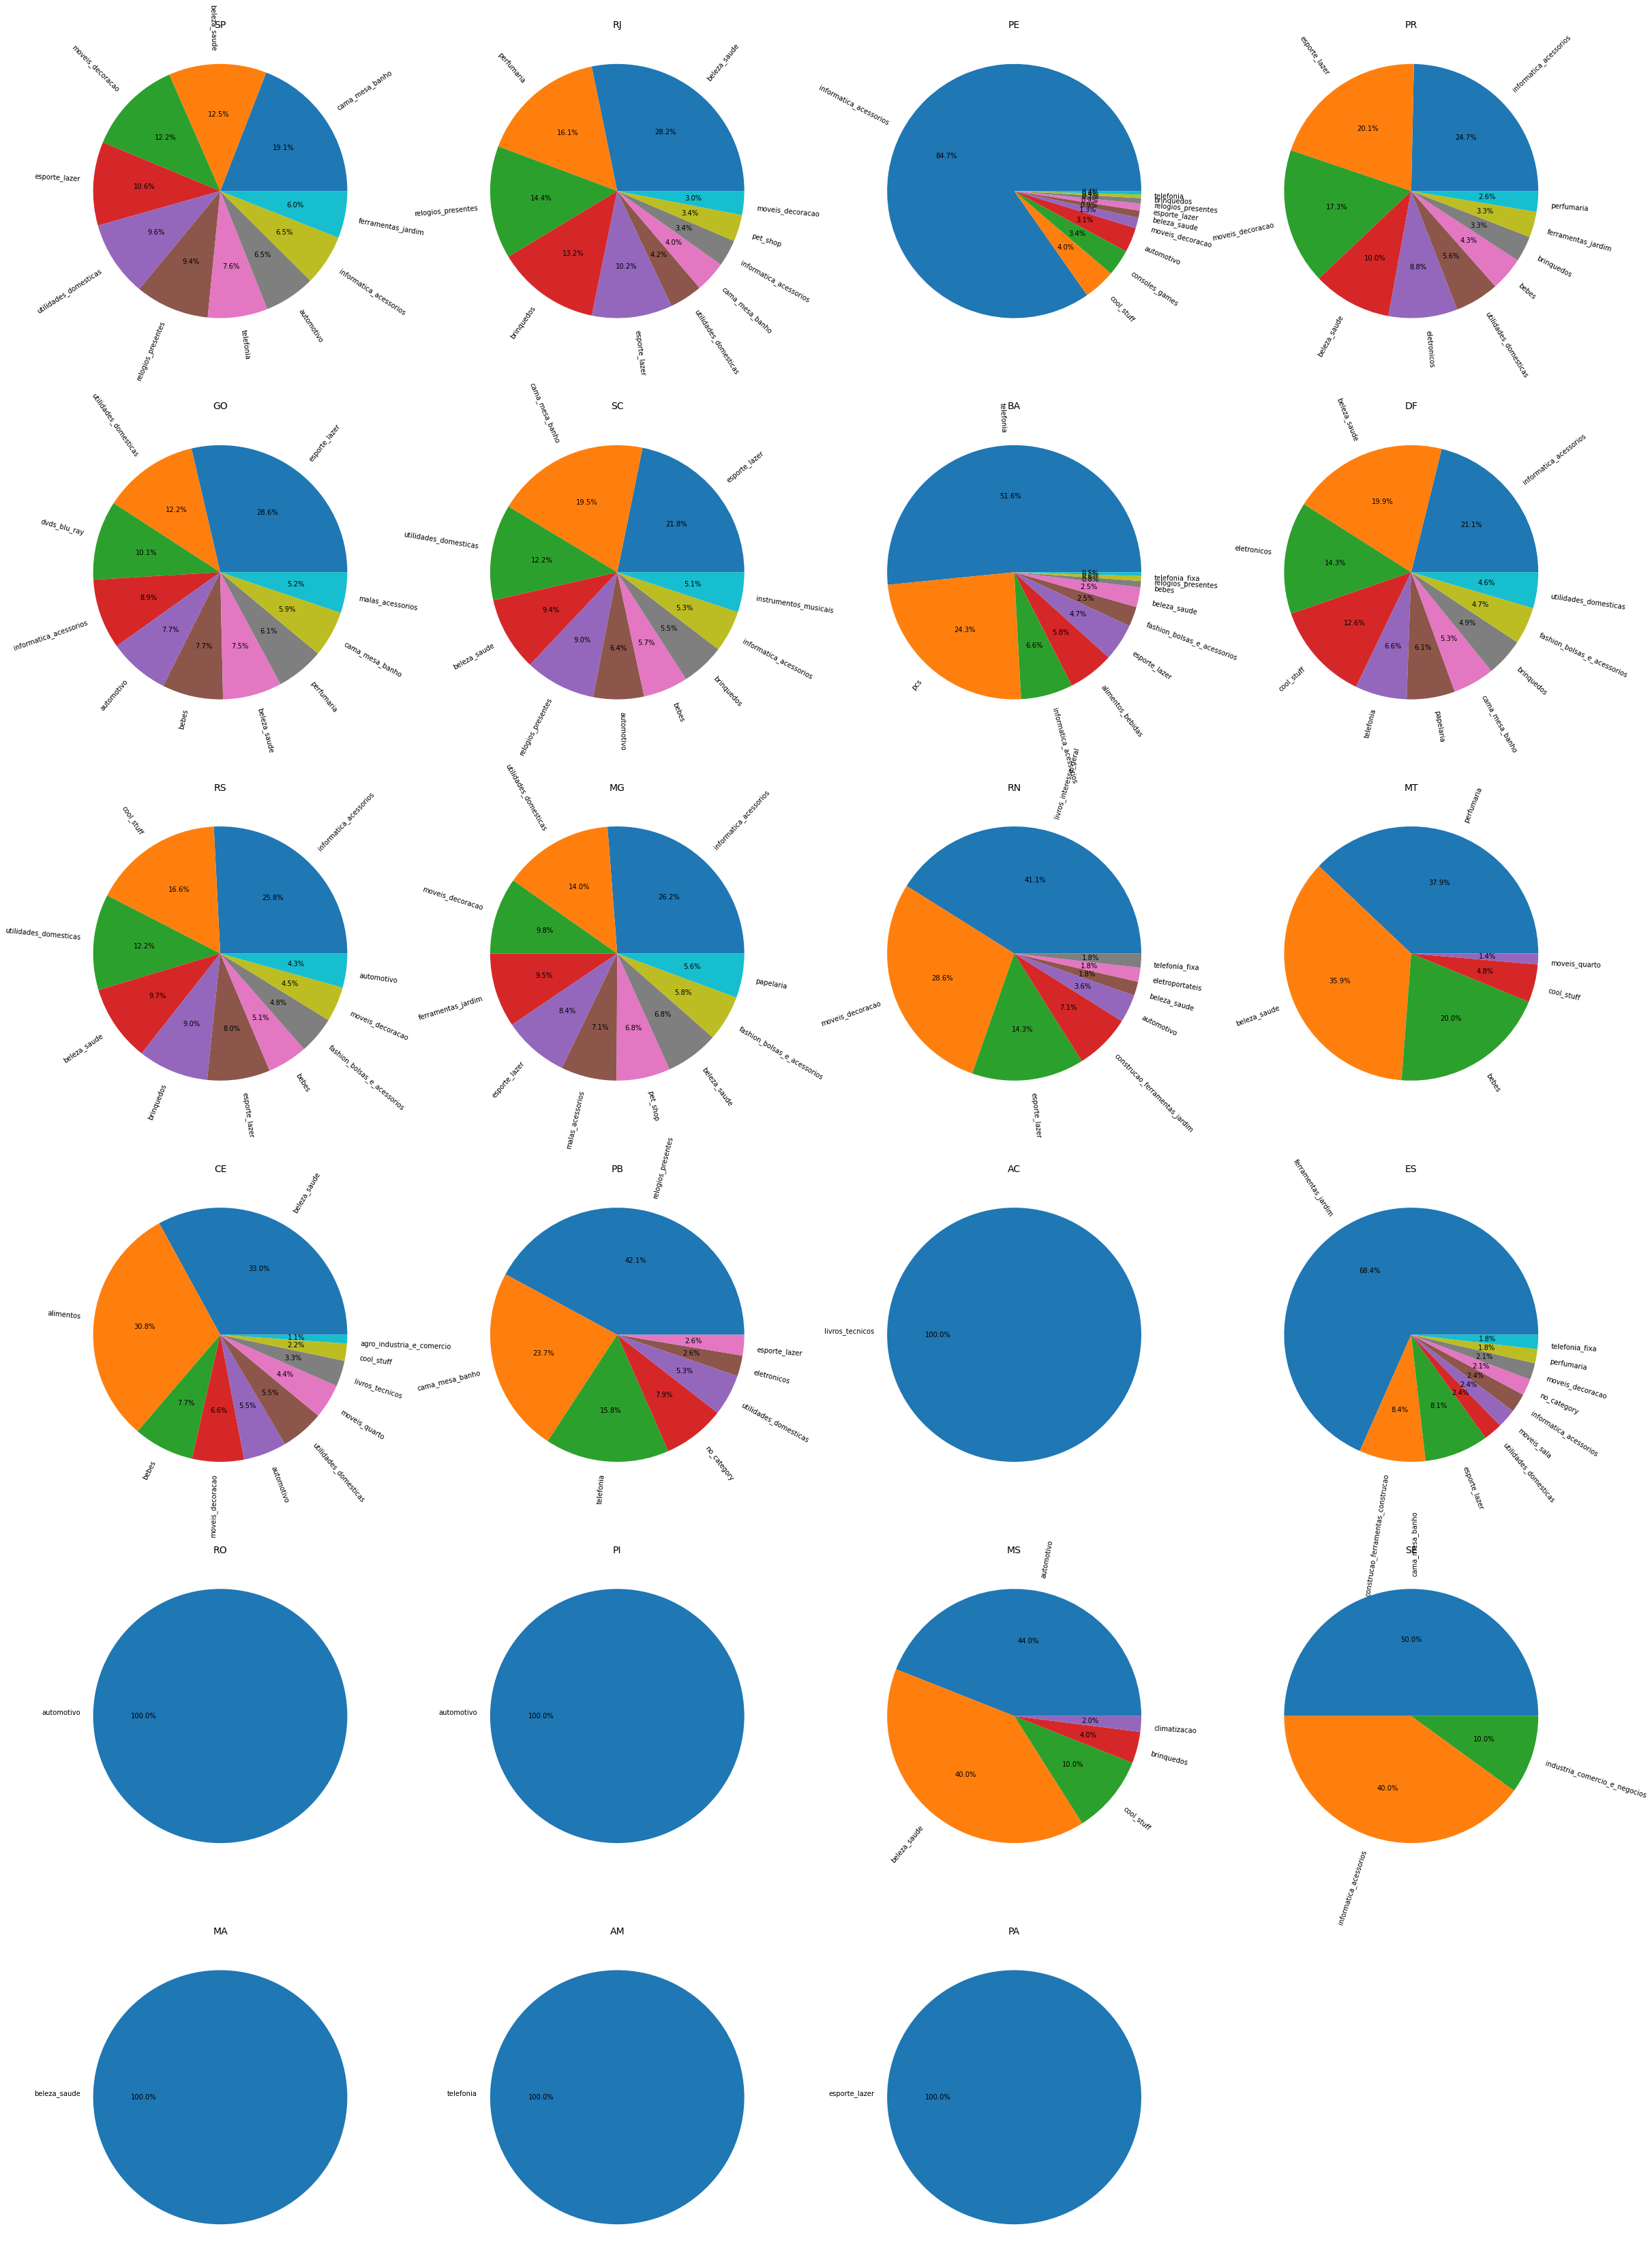

In [346]:
states = df_seller_product['seller_state'].unique().tolist()

height, width = 6, 4
fig = plt.figure(figsize=(40, 60))
for num, state in enumerate(states):

    state_product = df_seller_product.loc[df_seller_product['seller_state'] == state].groupby(
        by='product_category_name').count().reset_index().rename(columns={'seller_state': 'total_number'}).sort_values(by='total_number', ascending=False).head(10)

    plot = fig.add_subplot(height, width, num+1)
    plot.pie(state_product['total_number'],
             labels=state_product['product_category_name'], autopct='%.1f%%', rotatelabels=True)
    plot.set_title(state, fontsize=14)

plt.show()


*The above analysis of sold product categories by state shows the top 10 most sold product by category of each state. Some states have evenly distributed sales of each category but some products are very dominant in the whole sold products of some states. This could help the sellers to predict the future sales of products in each spesific category of each state. Furthermore, with the combination of analysis of the sold product volume, it could help sellers rent the right size of storehouses and emply the right zise of logistic team to meet the proper demand of products.*

### 3. Seller and Sold Product Volume

In [347]:
df_seller_product_volume = df_seller_price.merge(df_product, on='product_id', how='left')[
    ['seller_state', 'product_category_name', 'seller_city', 'product_length_cm', 'product_height_cm', 'product_width_cm']]
df_seller_product_volume


,seller_state,product_category_name,seller_city,product_length_cm,product_height_cm,product_width_cm
0,SP,esporte_lazer,campinas,43.0,15.0,35.0
1,SP,esporte_lazer,campinas,35.0,15.0,28.0
2,SP,esporte_lazer,campinas,16.0,5.0,15.0
3,SP,malas_acessorios,mogi guacu,55.0,37.0,30.0
4,SP,papelaria,mogi guacu,25.0,55.0,40.0
...,...,...,...,...,...,...
112645,RS,NaN,pelotas,50.0,5.0,11.0
112646,RS,NaN,pelotas,50.0,5.0,11.0
112647,RS,NaN,pelotas,50.0,5.0,11.0
112648,RS,NaN,pelotas,50.0,5.0,11.0


In [348]:
# Check if there is any missing value in dataset
df_seller_product_volume.isnull().sum()


seller_state                0
product_category_name    1603
seller_city                 0
product_length_cm          18
product_height_cm          18
product_width_cm           18
dtype: int64

In [349]:
# Fill the missing category value with string 'no_category'
df_seller_product_volume['product_category_name'].fillna(
    'no_category', inplace=True)

# Fill the missing product size value with mean value
product_measurement = ['product_length_cm',
                       'product_height_cm', 'product_width_cm']
for product in product_measurement:
    df_seller_product_volume[product].fillna(
        np.mean(df_seller_product_volume[product]), inplace=True)

df_seller_product_volume.isnull().sum()


seller_state             0
product_category_name    0
seller_city              0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [350]:
# Add a new product volume column
df_seller_product_volume['product_volume_m3'] = (df_seller_product_volume['product_length_cm'] *
                                                 df_seller_product_volume['product_height_cm'] * df_seller_product_volume['product_width_cm'])/10000
df_seller_product_volume


,seller_state,product_category_name,seller_city,product_length_cm,product_height_cm,product_width_cm,product_volume_m3
0,SP,esporte_lazer,campinas,43.0,15.0,35.0,2.2575
1,SP,esporte_lazer,campinas,35.0,15.0,28.0,1.4700
2,SP,esporte_lazer,campinas,16.0,5.0,15.0,0.1200
3,SP,malas_acessorios,mogi guacu,55.0,37.0,30.0,6.1050
4,SP,papelaria,mogi guacu,25.0,55.0,40.0,5.5000
...,...,...,...,...,...,...,...
112645,RS,no_category,pelotas,50.0,5.0,11.0,0.2750
112646,RS,no_category,pelotas,50.0,5.0,11.0,0.2750
112647,RS,no_category,pelotas,50.0,5.0,11.0,0.2750
112648,RS,no_category,pelotas,50.0,5.0,11.0,0.2750


#### -- Seller State and Sold Product Volume

In [351]:
df_seller_product_volume_bystate = df_seller_product_volume[['seller_state', 'product_volume_m3']].groupby(
    by='seller_state').sum().reset_index().sort_values(by='product_volume_m3', ascending=False).round(2)
df_seller_product_volume_bystate


,seller_state,product_volume_m3
22,SP,125372.89
8,MG,13560.97
15,PR,12906.60
20,SC,7053.31
16,RJ,5299.49
19,RS,3594.19
4,DF,879.42
2,BA,820.66
5,ES,669.61
6,GO,468.76


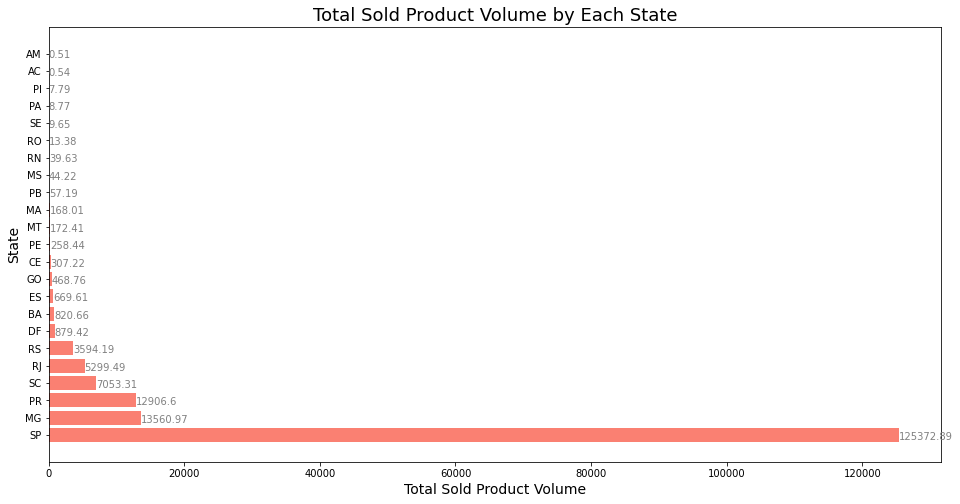

In [352]:
plt.figure(figsize=(16, 8))

plt.barh(df_seller_product_volume_bystate['seller_state'],
         df_seller_product_volume_bystate['product_volume_m3'], color='salmon')

y = df_seller_product_volume_bystate['product_volume_m3'].values
for index, value in enumerate(y):
    plt.text(value, index+0.2, str(value), va='top', color='grey')

plt.ticklabel_format(axis='x', style='plain')

plt.title("Total Sold Product Volume by Each State", fontsize=18)
plt.ylabel('State', fontsize=14)
plt.xlabel('Total Sold Product Volume', fontsize=14)
plt.show()


#### -- Seller City and Sold Product Volume

In [353]:
df_seller_product_volume_bycity = df_seller_product_volume[['seller_city', 'product_volume_m3']].groupby(
    by='seller_city').sum().reset_index().sort_values(by='product_volume_m3', ascending=False).round(2)
df_seller_product_volume_bycity = df_seller_product_volume_bycity.iloc[0:10]
df_seller_product_volume_bycity


,seller_city,product_volume_m3
517,sao paulo,36349.97
227,ibitinga,11880.44
258,itaquaquecetuba,11558.63
507,sao jose do rio preto,6030.97
220,guarulhos,5783.74
159,curitiba,4883.28
106,campo limpo paulista,3850.03
450,rio de janeiro,3351.25
471,santa barbara d´oeste,3149.21
64,belo horizonte,3013.04


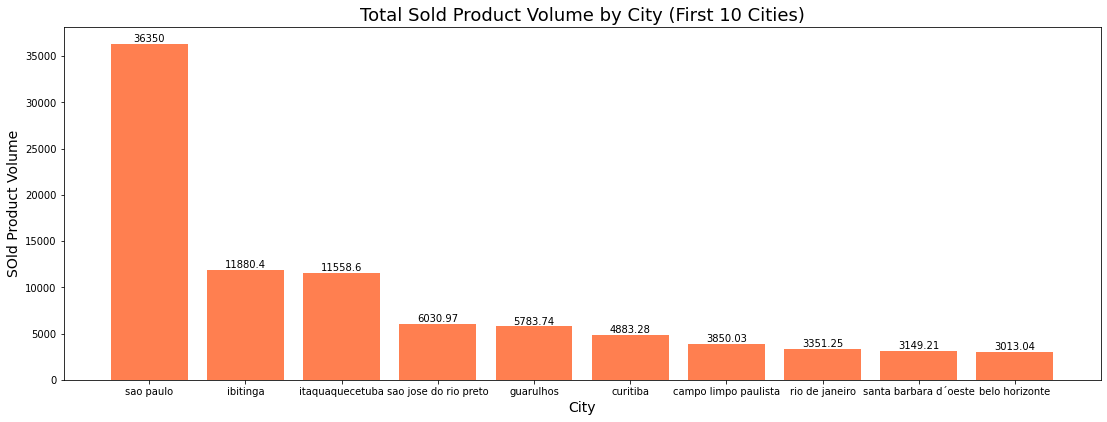

In [354]:
ax = plt.figure(figsize=(16, 7)).add_axes([0, 0, 0.9, 0.7])
bars = ax.bar(df_seller_product_volume_bycity['seller_city'],
              df_seller_product_volume_bycity['product_volume_m3'], color='coral')
ax.bar_label(bars)

ax.set_title("Total Sold Product Volume by City (First 10 Cities)", fontsize=18)
ax.set_xlabel('City', fontsize=14)
ax.set_ylabel('SOld Product Volume', fontsize=14)
plt.show()


*From the above two charts we can have a general picture of how much volume of the products sold by each state and furthermore, by each city (Only the first 10 cities were shown here). This could help the sellers to better arrange their storage room. Next, let's see what's the volume required by of each category of each city (We will use again the first 10 cities as example).*

#### -- Seller City and Sold Product Volume by Category

In [355]:
df_seller_product_volume_bycity_ca = df_seller_product_volume[[
    'seller_city', 'product_volume_m3', 'product_category_name']]
df_seller_product_volume_bycity_ca


,seller_city,product_volume_m3,product_category_name
0,campinas,2.2575,esporte_lazer
1,campinas,1.4700,esporte_lazer
2,campinas,0.1200,esporte_lazer
3,mogi guacu,6.1050,malas_acessorios
4,mogi guacu,5.5000,papelaria
...,...,...,...
112645,pelotas,0.2750,no_category
112646,pelotas,0.2750,no_category
112647,pelotas,0.2750,no_category
112648,pelotas,0.2750,no_category


In [356]:
# For a better illustration of this study, we only pick the top 10 cities with their top 10 sold product categories by volume
# Pick top 10 cities names
top10_city_name = df_seller_product_volume_bycity['seller_city'].values.tolist(
)
top10_city_name


['sao paulo',
 'ibitinga',
 'itaquaquecetuba',
 'sao jose do rio preto',
 'guarulhos',
 'curitiba',
 'campo limpo paulista',
 'rio de janeiro',
 'santa barbara d´oeste',
 'belo horizonte']

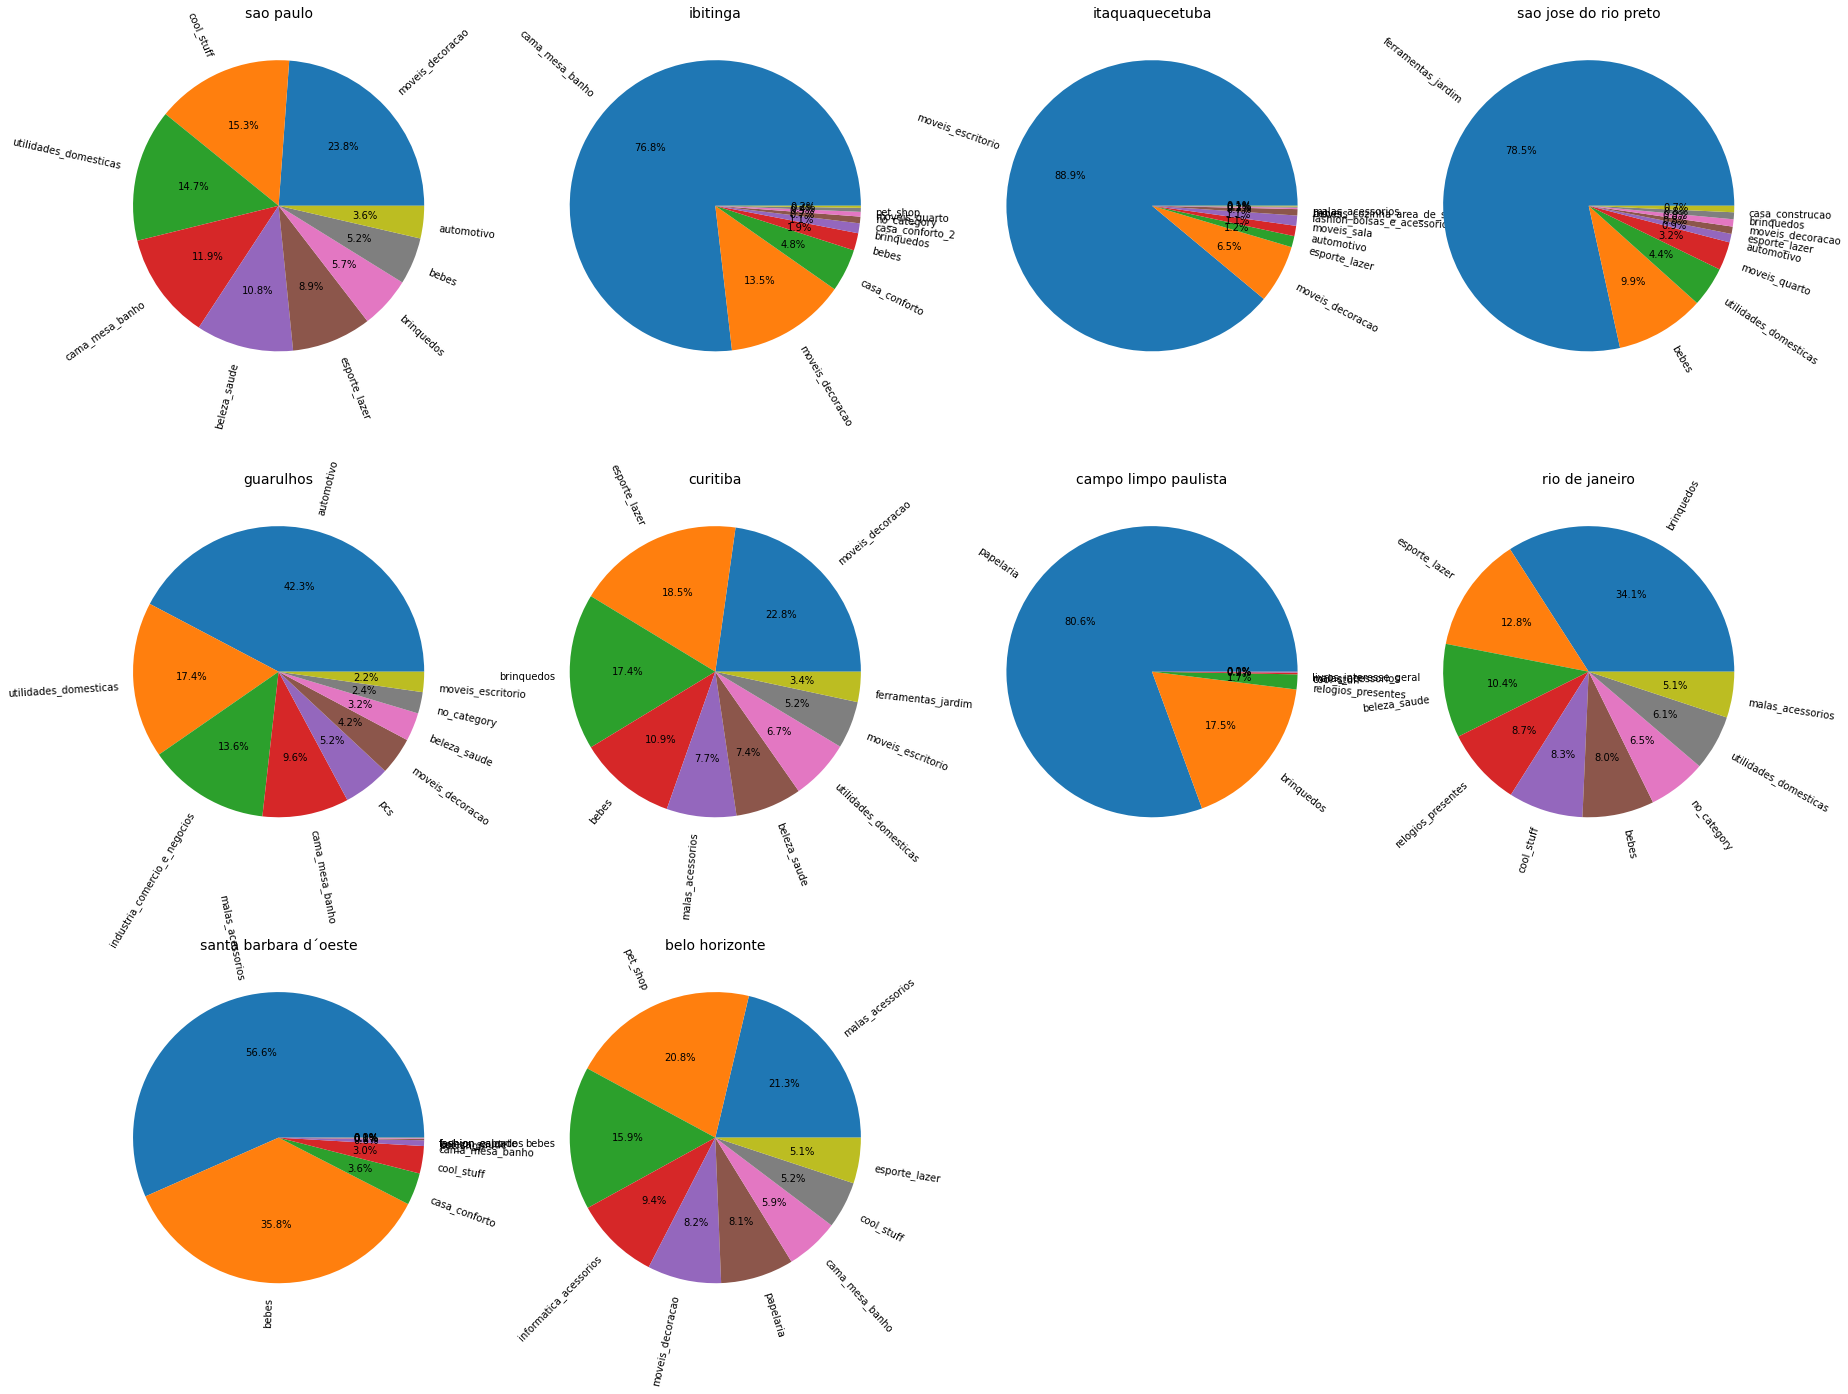

In [357]:
height, width = 6, 4
fig = plt.figure(figsize=(30, 50))
for num, city in enumerate(top10_city_name):

    product_sold_volume_bycity = df_seller_product_volume_bycity_ca.loc[df_seller_product_volume_bycity_ca['seller_city']
                                                                        == city].groupby(by='product_category_name').sum().reset_index().sort_values(by='product_volume_m3', ascending=False)[0:9]

    plot = fig.add_subplot(height, width, num+1)
    plot.pie(product_sold_volume_bycity['product_volume_m3'],
             labels=product_sold_volume_bycity['product_category_name'], autopct='%.1f%%', rotatelabels=True)
    plot.set_title(city, fontsize=14)

plt.show()


*With further study like this, we can help the seller to orgaanize their storehouse with much more details(e.g How much storage space each category requires in each city). So the sellers can arrange the space depending on various conditions that different products require.*

### 4. Seller and Orders


In [358]:
df_orders = pd.read_csv('datasets/olist_orders_dataset.csv')
df_seller_orders = df_seller.join(
    df_items['order_id']).merge(df_orders, on='order_id')
df_seller_orders.head(3)


,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00


In [359]:
# Check if there is any missing value in dataset
df_seller_orders.isnull().sum()


seller_id                         0
seller_zip_code_prefix            0
seller_city                       0
seller_state                      0
order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                 0
order_delivered_carrier_date     35
order_delivered_customer_date    68
order_estimated_delivery_date     0
dtype: int64

In [360]:
# Check if any missing values are not in the right column
# And if the total number matches (35 and 68) with the results above, we can say they are valid missing values due to different order status
order_status = df_seller_orders['order_status'].unique()

carrier_date_null_values_total = {}
customer_date_null_values_total = {}

total_carrier_date = 0
total_customer_date = 0

for status in order_status:
    carrier_date_null_values = df_seller_orders[['order_status', 'order_delivered_carrier_date',
                                                 'order_delivered_customer_date']].loc[df_seller_orders['order_status'] == status].isnull().sum().get('order_delivered_carrier_date')

    customer_date_null_values = df_seller_orders[['order_status', 'order_delivered_carrier_date',
                                                  'order_delivered_customer_date']].loc[df_seller_orders['order_status'] == status].isnull().sum().get('order_delivered_customer_date')

    carrier_date_null_values_total[status] = carrier_date_null_values
    total_carrier_date += carrier_date_null_values

    customer_date_null_values_total[status] = customer_date_null_values
    total_customer_date += customer_date_null_values


print(carrier_date_null_values_total)
print(f'Total number of missing carrier date values: {total_carrier_date}')

print(carrier_date_null_values_total)
print(f'Total number of missing customer date values: {total_customer_date}')


{'delivered': 0, 'shipped': 0, 'canceled': 18, 'invoiced': 7, 'processing': 10}
Total number of missing carrier date values: 35
{'delivered': 0, 'shipped': 0, 'canceled': 18, 'invoiced': 7, 'processing': 10}
Total number of missing customer date values: 68


In [361]:
# Convert all the time date to timestamp values
# Next, check all the time values to see if there is any fault
date_values = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
               'order_delivered_customer_date', 'order_estimated_delivery_date']

max_date_values = {}
min_date_values = {}

for date_value in date_values:
    
    df_seller_orders[date_value] = pd.to_datetime(df_seller_orders[date_value])

    max_date = max(df_seller_orders[date_value])
    min_date = min(df_seller_orders[date_value])
    
    max_date_values[date_value] = max_date
    min_date_values[date_value] = min_date

print(max_date_values)
print(min_date_values)
    

{'order_purchase_timestamp': Timestamp('2018-08-29 14:52:00'), 'order_approved_at': Timestamp('2018-08-29 15:05:22'), 'order_delivered_carrier_date': Timestamp('2018-08-29 20:01:00'), 'order_delivered_customer_date': Timestamp('2018-09-17 14:42:46'), 'order_estimated_delivery_date': Timestamp('2018-10-01 00:00:00')}
{'order_purchase_timestamp': Timestamp('2016-10-04 19:01:13'), 'order_approved_at': Timestamp('2016-10-06 15:43:49'), 'order_delivered_carrier_date': Timestamp('2016-10-13 14:35:21'), 'order_delivered_customer_date': Timestamp('2016-10-16 15:35:21'), 'order_estimated_delivery_date': Timestamp('2016-11-28 00:00:00')}


#### -- Seller State and Order Approval Time


In [362]:
df_seller_state_order_approval_time = df_seller_orders[[
    'seller_state', 'order_purchase_timestamp', 'order_approved_at']]
df_seller_state_order_approval_time['order_approval_time'] = df_seller_state_order_approval_time['order_approved_at'] - \
    df_seller_state_order_approval_time['order_purchase_timestamp']

df_seller_state_order_approval_time


/tmp/ipykernel_2713/2781671718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_approval_time['order_approval_time'] = df_seller_state_order_approval_time['order_approved_at'] - \


,seller_state,order_purchase_timestamp,order_approved_at,order_approval_time
0,SP,2017-09-13 08:59:02,2017-09-13 09:45:35,0 days 00:46:33
1,SP,2017-04-26 10:53:06,2017-04-26 11:05:13,0 days 00:12:07
2,RJ,2018-01-14 14:33:31,2018-01-14 14:48:30,0 days 00:14:59
3,SP,2018-08-08 10:00:35,2018-08-08 10:10:18,0 days 00:09:43
4,SP,2017-02-04 13:57:51,2017-02-04 14:10:13,0 days 00:12:22
...,...,...,...,...
3090,PR,2018-04-12 10:23:19,2018-04-12 10:35:13,0 days 00:11:54
3091,SC,2017-01-17 14:50:19,2017-01-17 15:02:24,0 days 00:12:05
3092,SP,2018-08-08 21:39:41,2018-08-08 21:55:12,0 days 00:15:31
3093,RS,2018-07-05 11:52:08,2018-07-05 16:11:09,0 days 04:19:01


In [363]:
df_seller_state_order_approval_time['order_approval_time_min'] = df_seller_state_order_approval_time['order_approval_time'].map(
    lambda x: x.total_seconds() / 60)

df_seller_state_order_approval_time.drop(
    columns=['order_approval_time', 'order_purchase_timestamp', 'order_approved_at'], axis=1, inplace=True)


/tmp/ipykernel_2713/78055329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_approval_time['order_approval_time_min'] = df_seller_state_order_approval_time['order_approval_time'].map(
/tmp/ipykernel_2713/78055329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_approval_time.drop(


In [364]:
df_seller_state_order_approval_time = df_seller_state_order_approval_time.round(
    2)
df_seller_state_order_approval_time


,seller_state,order_approval_time_min
0,SP,46.55
1,SP,12.12
2,RJ,14.98
3,SP,9.72
4,SP,12.37
...,...,...
3090,PR,11.90
3091,SC,12.08
3092,SP,15.52
3093,RS,259.02


In [365]:
seller_median_order_approval_time_min = {}
for state in states:
    seller_median_order_approval_time_min[state] = df_seller_state_order_approval_time.loc[df_seller_state_order_approval_time['seller_state']
                                                                                           == state]['order_approval_time_min'].median()
print(seller_median_order_approval_time_min)


{'SP': 20.6, 'RJ': 16.5, 'PE': 17.58, 'PR': 18.83, 'GO': 22.16, 'SC': 19.72, 'BA': 13.88, 'DF': 22.17, 'RS': 18.48, 'MG': 22.325, 'RN': 1584.05, 'MT': 462.17, 'CE': 96.07, 'PB': 16.065, 'AC': 4946.63, 'ES': 89.32, 'RO': 2254.29, 'PI': 15.12, 'MS': 97.22, 'SE': 748.275, 'MA': 496.0, 'AM': 6.02, 'PA': 16.75}


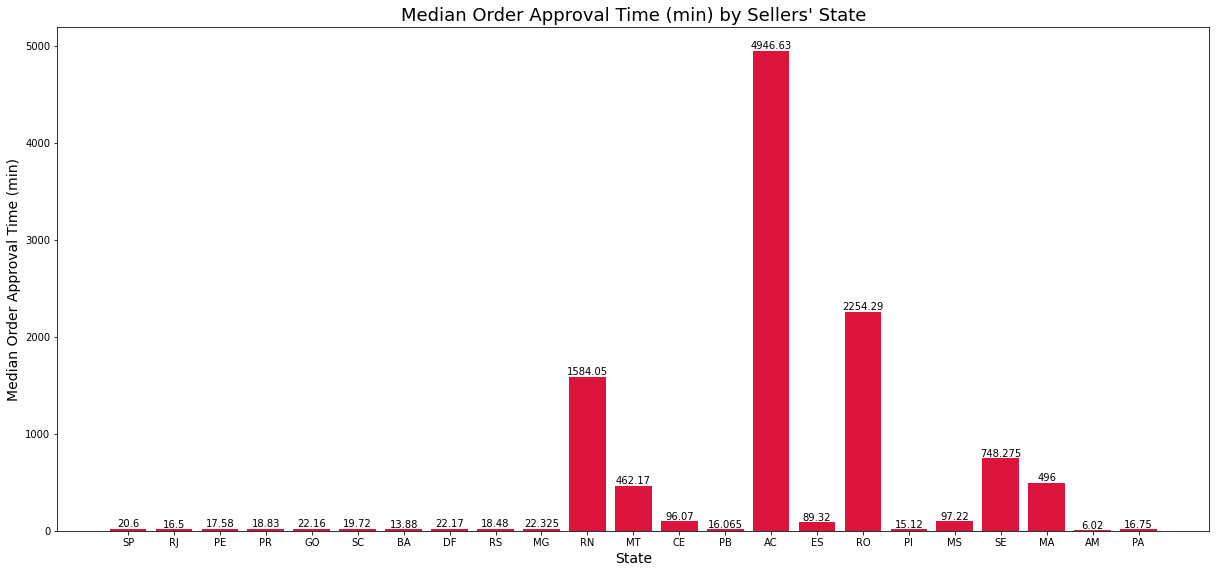

In [366]:
ax = plt.figure(figsize=(16, 7)).add_axes([0, 0, 1, 1])
bars = ax.bar(seller_median_order_approval_time_min.keys(),
              seller_median_order_approval_time_min.values(), color='crimson')
ax.bar_label(bars)

ax.set_title("Median Order Approval Time (min) by Sellers' State", fontsize=18)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Median Order Approval Time (min)', fontsize=14)
plt.show()


From this chart we can see there are several states of which the median order approval time are extremely longer than usual, let's check the order numbers to find out if this is abnormal.

In [367]:
states_names_with_abnormal_approval_time = [
    'RN', 'MT', 'AC', 'RO', 'SE', 'MA',  'CE', 'ES', 'MS']
states_with_abnormal_approval_time = {}

for state in states_names_with_abnormal_approval_time:
    states_with_abnormal_approval_time[state] = df_seller_state_order_approval_time.loc[
        df_seller_state_order_approval_time['seller_state'] == state]['seller_state'].count()

print(states_with_abnormal_approval_time)

{'RN': 5, 'MT': 4, 'AC': 1, 'RO': 2, 'SE': 2, 'MA': 1, 'CE': 13, 'ES': 23, 'MS': 5}


From here we can see the states with above 100min approval time have very few orders (e.g RN has 5, AC has 1) and states with around 90min approval time have relatively more orders (e.g CE has 13, ES has 23). So in this case, the extreme long approval time might be because the sellers are still working on their selling systems. With more orders to happen in the future, hopefully the median order approval time should become more normal like other states with 10-20min. 

#### -- Seller State and Order Delivered Time (After Order Approval)

In [368]:
df_seller_state_order_delivering_time = df_seller_orders[[
    'seller_state', 'order_approved_at', 'order_delivered_customer_date']]
df_seller_state_order_delivering_time['order_delivering_time'] = df_seller_state_order_delivering_time['order_delivered_customer_date'] - \
    df_seller_state_order_delivering_time['order_approved_at']

df_seller_state_order_delivering_time


/tmp/ipykernel_2713/1750655888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_delivering_time['order_delivering_time'] = df_seller_state_order_delivering_time['order_delivered_customer_date'] - \


,seller_state,order_approved_at,order_delivered_customer_date,order_delivering_time
0,SP,2017-09-13 09:45:35,2017-09-20 23:43:48,7 days 13:58:13
1,SP,2017-04-26 11:05:13,2017-05-12 16:04:24,16 days 04:59:11
2,RJ,2018-01-14 14:48:30,2018-01-22 13:19:16,7 days 22:30:46
3,SP,2018-08-08 10:10:18,2018-08-14 13:32:39,6 days 03:22:21
4,SP,2017-02-04 14:10:13,2017-03-01 16:42:31,25 days 02:32:18
...,...,...,...,...
3090,PR,2018-04-12 10:35:13,2018-04-24 18:41:15,12 days 08:06:02
3091,SC,2017-01-17 15:02:24,2017-01-30 14:36:28,12 days 23:34:04
3092,SP,2018-08-08 21:55:12,2018-08-13 14:36:32,4 days 16:41:20
3093,RS,2018-07-05 16:11:09,2018-07-10 18:06:35,5 days 01:55:26


In [369]:
df_seller_state_order_delivering_time['order_delivering_time_days'] = df_seller_state_order_delivering_time['order_delivering_time'].map(
    lambda x: x.total_seconds() / (60*60*24))

df_seller_state_order_delivering_time.drop(
    columns=['order_approved_at', 'order_delivered_customer_date', 'order_delivering_time'], axis=1, inplace=True)


/tmp/ipykernel_2713/396346123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_delivering_time['order_delivering_time_days'] = df_seller_state_order_delivering_time['order_delivering_time'].map(
/tmp/ipykernel_2713/396346123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller_state_order_delivering_time.drop(


In [370]:
df_seller_state_order_delivering_time = df_seller_state_order_delivering_time.round(
    2)
df_seller_state_order_delivering_time


,seller_state,order_delivering_time_days
0,SP,7.58
1,SP,16.21
2,RJ,7.94
3,SP,6.14
4,SP,25.11
...,...,...
3090,PR,12.34
3091,SC,12.98
3092,SP,4.70
3093,RS,5.08


In [371]:
seller_median_order_delivering_time_days = {}
for state in states:
    seller_median_order_delivering_time_days[state] = df_seller_state_order_delivering_time.loc[df_seller_state_order_delivering_time['seller_state']
                                                                                                == state]['order_delivering_time_days'].median()
print(seller_median_order_delivering_time_days)


{'SP': 9.49, 'RJ': 9.28, 'PE': 11.5, 'PR': 9.13, 'GO': 11.02, 'SC': 9.855, 'BA': 10.51, 'DF': 8.96, 'RS': 9.635000000000002, 'MG': 9.445, 'RN': 6.43, 'MT': 8.935, 'CE': 11.365, 'PB': 18.01, 'AC': 7.35, 'ES': 8.870000000000001, 'RO': 11.66, 'PI': 19.6, 'MS': 8.29, 'SE': 4.745, 'MA': 3.68, 'AM': 27.24, 'PA': 4.3}


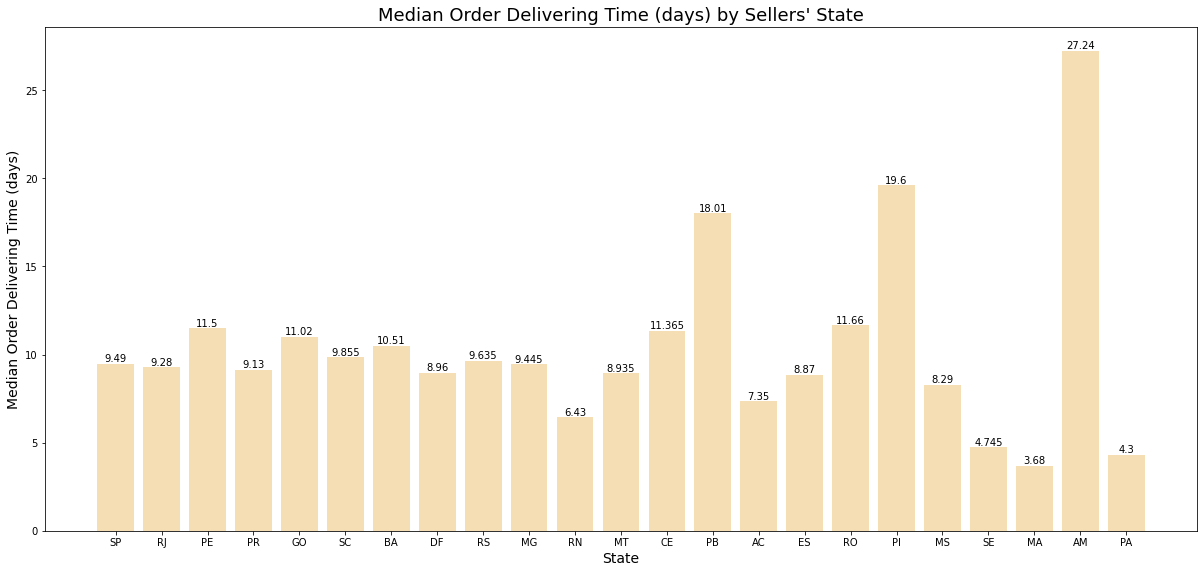

In [372]:
ax = plt.figure(figsize=(16, 7)).add_axes([0, 0, 1, 1])
bars = ax.bar(seller_median_order_delivering_time_days.keys(),
              seller_median_order_delivering_time_days.values(), color='wheat')
ax.bar_label(bars)

ax.set_title("Median Order Delivering Time (days) by Sellers' State", fontsize=18)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Median Order Delivering Time (days)', fontsize=14)
plt.show()


Most of states can deliver their orders with 8 -12 days. AM, PI, PB have much longer delivering time comparing to others states. It might because the sellers in those three states are still working on their workflows. The retail could help the them there in the future if it becomes a problem that cannot be fixed by sellers themselves.